# Introduction

cuDF is a Python GPU DataFrame library (built on the Apache Arrow columnar memory format) for loading, joining, aggregating, filtering, and otherwise manipulating tabular data using a DataFrame style API in the style of pandas.

cuDF includes a pandas accelerator mode (`cudf.pandas`), enabling you to accelerate your pandas workflows without requiring any code change.

This notebook highlights the impact of GPU-acceleration for common operations and analytical questions analyzing a real-world dataset of stock prices.

For a deeper introduction and insight into how things work under the hood, we encourage you to run the [10 Minutes to RAPIDS cuDF's pandas accelerator mode Colab notebook](https://nvda.ws/rapids-cudf) or visit https://rapids.ai/cudf-pandas/.

# ⚠️ Verify your setup

First, we'll verify that you are running with an NVIDIA GPU.

In [1]:
!nvidia-smi  # this should display information about available GPUs

Tue Feb  4 22:00:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

With our GPU-enabled Colab runtime active, we're ready to go. cuDF is available by default in the GPU-enabled runtime.

# Download the data

The data we'll be working with is a subset of the [USA 514 Stocks Prices NASDAQ NYSE dataset](https://www.kaggle.com/datasets/olegshpagin/usa-stocks-prices-ohlcv) from Kaggle.

We'll start by downloading the dataset from NVIDIA's Public Google Cloud Storage bucket to provide faster download speeds to Colab.  This should take under 30 seconds.

In [2]:
!if [ ! -f "usa_stocks_30m.parquet" ]; then curl https://storage.googleapis.com/rapidsai/colab-data/usa_stocks_30m.parquet -o usa_stocks_30m.parquet; else echo "usa_stocks_30m.parquet found"; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  633M  100  633M    0     0  92.5M      0  0:00:06  0:00:06 --:--:--  106M


# Analysis using Standard Pandas



In [3]:
import pandas as pd

In [4]:
%time df = pd.read_parquet("usa_stocks_30m.parquet")
df.info()

CPU times: user 4.49 s, sys: 3.41 s, total: 7.9 s
Wall time: 5.48 s
<class 'pandas.core.frame.DataFrame'>
Index: 36087094 entries, 0 to 36919
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   datetime  datetime64[ms]
 1   open      float64       
 2   high      float64       
 3   low       float64       
 4   close     float64       
 5   volume    int64         
 6   ticker    object        
dtypes: datetime64[ms](1), float64(4), int64(1), object(1)
memory usage: 2.2+ GB


In [5]:
df.head()

,datetime,open,high,low,close,volume,ticker
0,1999-11-18 17:00:00,45.56,50.00,45.50,46.00,9275000,A
1,1999-11-18 17:30:00,46.00,47.69,45.82,46.57,3200900,A
2,1999-11-18 18:00:00,46.56,46.63,41.00,41.00,3830500,A
3,1999-11-18 18:30:00,41.00,43.38,40.37,42.38,3688600,A
4,1999-11-18 19:00:00,42.31,42.44,41.56,41.69,1584300,A


We've got about 36M rows and 7 columns, covering stock price and trading-related attributes (`open`, `close`, etc.) for various companies (`ticker`) at what looks like 30 minute intervals.

Let's look at the more detailed summary statistics for the the numeric data.

To fit this analysis on Colab's free tier without running out of the 12GB of CPU memory, we'll only use the first 18 million rows of this dataset. If you'd like to process the full dataset, you can [sign up a Colab Pro account](https://colab.research.google.com/signup)!


In [6]:
df = df.iloc[:18000000]

In [8]:
%time df.describe()

CPU times: user 2.71 s, sys: 345 ms, total: 3.06 s
Wall time: 3.09 s


,datetime,open,high,low,close,volume
count,18000000,1.800000e+07,1.800000e+07,1.800000e+07,1.800000e+07,1.800000e+07
mean,2012-07-01 06:57:04.401000,8.588868e+01,8.613226e+01,8.564169e+01,8.588910e+01,3.816898e+05
min,1998-01-02 16:30:00,1.200000e-01,1.200000e-01,0.000000e+00,1.200000e-01,0.000000e+00
25%,2006-07-06 22:00:00,3.318000e+01,3.328000e+01,3.306000e+01,3.318000e+01,2.928900e+04
50%,2013-01-17 19:30:00,5.324000e+01,5.340000e+01,5.308000e+01,5.324000e+01,8.060000e+04
75%,2018-11-19 18:00:00,9.010000e+01,9.035000e+01,8.987000e+01,9.010000e+01,2.250070e+05
max,2024-03-13 23:00:00,3.906580e+03,3.918000e+03,3.903850e+03,3.904240e+03,7.465168e+08
std,NaN,1.406006e+02,1.409601e+02,1.402315e+02,1.405988e+02,1.933480e+06


A little slow, but it gets the job done.

Most of the price-related columns look well behaved with no crazy outliers based on the max values. Volume has a high variance, but that makes sense as some stocks will be traded **much** more often than others. We've also got a wide time range in this data, spanning 1998 to 2024.

The time-range information feels important. This is per-stock data, so some stocks will have "entered" the dataset at different times. We should really group by each ticker for our analysis.

To start, we can investigate the time periods for various stocks in the data.

In [9]:
%time df.groupby("ticker").agg({"datetime": ["min", "max", "count"]})

CPU times: user 1.19 s, sys: 234 ms, total: 1.42 s
Wall time: 1.43 s


datetime                           
                       min                 max  count
ticker                                               
A      1999-11-18 17:00:00 2024-03-13 23:00:00  79922
AAL    2013-12-09 16:30:00 2024-03-13 23:00:00  34174
AAPL   1998-01-02 16:30:00 2024-03-13 23:00:00  86218
ABBV   2013-01-02 16:30:00 2024-03-13 23:00:00  36770
ABNB   2020-12-10 20:30:00 2024-03-13 23:00:00  11274
...                    ...                 ...    ...
IVZ    2007-05-24 16:30:00 2024-03-13 23:00:00  55490
J      2007-05-02 21:00:00 2024-03-13 23:00:00  55672
JBHT   1998-01-02 16:30:00 2024-03-13 22:30:00  85498
JBL    1998-05-05 16:30:00 2024-03-13 23:00:00  84976
JCI    1998-01-02 16:30:00 2003-02-20 19:00:00  16693

[264 rows x 3 columns]

As expected, there's a pretty significant difference across stocks. Since this determines how many records exist for each ticker, we'll need to take that into account for future analysis.

One way to do that is to use the time periods as part of any grouping or rolling window analysis we do on this data. For example, we can look at the minimum and maximum of each stock ticker at various time frequencies to understand trends.

In [10]:
%%time
df[["year", "week", "day"]] = df.datetime.dt.isocalendar()
df.groupby(["ticker", "year", "week"]).agg({"close": ["min", "max"]})

CPU times: user 2.15 s, sys: 697 ms, total: 2.85 s
Wall time: 2.84 s


close       
                    min    max
ticker year week              
A      1999 46    40.06  46.57
            47    40.07  43.07
            48    41.00  45.56
            49    44.56  46.32
            50    41.06  46.88
...                 ...    ...
JCI    2003 4     79.10  81.13
            5     78.86  80.98
            6     79.95  81.51
            7     77.72  81.33
            8     79.09  80.87

[286642 rows x 2 columns]

Okay, that was a little slow, but it's manageable. We can easily aggregate the data up to weekly values and investigate further.

But what if we want to ask slightly more complex questions?

## More complex analysis


Let's say we want the daily rolling average of all of these values for each stock. With this, we could investigate how each 30 minute interval compares to the rolling average over the course of a day.

In this **specific** demo dataset, we have exactly one record per 30 minutes, so we could use a fixed window size of 12 (12 periods per market day). But in practice, we often have messy data with inconsistent time frequencies -- not to mention some missing or duplicated data. Fixed time windows can potentially corrupt our analysis.

Fortunately, solving this problem is actually pretty easy with pandas. We can use a fixed **time window** per ticker rather than fixed number of records.

Unfortunately, it's **pretty** slow.

In [11]:
%time result = df.set_index("datetime").sort_index().groupby("ticker").rolling("1D").mean().reset_index()
result.head()

CPU times: user 17 s, sys: 7.14 s, total: 24.2 s
Wall time: 24.4 s


,ticker,datetime,open,high,low,close,volume,year,week,day
0,A,1999-11-18 17:00:00,45.560,50.000000,45.500000,46.000000,9.275000e+06,1999.0,46.0,4.0
1,A,1999-11-18 17:30:00,45.780,48.845000,45.660000,46.285000,6.237950e+06,1999.0,46.0,4.0
2,A,1999-11-18 18:00:00,46.040,48.106667,44.106667,44.523333,5.435467e+06,1999.0,46.0,4.0
3,A,1999-11-18 18:30:00,44.780,46.925000,43.172500,43.987500,4.998750e+06,1999.0,46.0,4.0
4,A,1999-11-18 19:00:00,44.286,46.028000,42.850000,43.528000,4.315860e+06,1999.0,46.0,4.0


**About** a 20 to 30 seconds just for a single question. That's not ideal.  Especially for what comes next.

Now that we have an average price per day, let's do this again to get the Simple Moving Averages (SMA) usually used in stock analysis.  We'll first do the 50 Day SMA and then the 200 Day SMA.

In [ ]:
%time fiftyDay = df.set_index("datetime").sort_index().groupby("ticker").rolling("50D").mean().reset_index()
fiftyDay.head()

CPU times: user 18.4 s, sys: 6.89 s, total: 25.3 s
Wall time: 25.6 s


,ticker,datetime,open,high,low,close,volume,year,week,day
0,A,1999-11-18 17:00:00,45.560,50.000000,45.500000,46.000000,9.275000e+06,1999.0,46.0,4.0
1,A,1999-11-18 17:30:00,45.780,48.845000,45.660000,46.285000,6.237950e+06,1999.0,46.0,4.0
2,A,1999-11-18 18:00:00,46.040,48.106667,44.106667,44.523333,5.435467e+06,1999.0,46.0,4.0
3,A,1999-11-18 18:30:00,44.780,46.925000,43.172500,43.987500,4.998750e+06,1999.0,46.0,4.0
4,A,1999-11-18 19:00:00,44.286,46.028000,42.850000,43.528000,4.315860e+06,1999.0,46.0,4.0


In [ ]:
%time twoHunDay = df.set_index("datetime").sort_index().groupby("ticker").rolling("200D").mean().reset_index()
twoHunDay.head()

CPU times: user 18.2 s, sys: 5.89 s, total: 24.1 s
Wall time: 24.3 s


,ticker,datetime,open,high,low,close,volume,year,week,day
0,A,1999-11-18 17:00:00,45.560,50.000000,45.500000,46.000000,9.275000e+06,1999.0,46.0,4.0
1,A,1999-11-18 17:30:00,45.780,48.845000,45.660000,46.285000,6.237950e+06,1999.0,46.0,4.0
2,A,1999-11-18 18:00:00,46.040,48.106667,44.106667,44.523333,5.435467e+06,1999.0,46.0,4.0
3,A,1999-11-18 18:30:00,44.780,46.925000,43.172500,43.987500,4.998750e+06,1999.0,46.0,4.0
4,A,1999-11-18 19:00:00,44.286,46.028000,42.850000,43.528000,4.315860e+06,1999.0,46.0,4.0


This took just about a minute and a half to get to just about where you can plot.  

Perfect time to switch to cudf.pandas. Let's do that and then run the **same code**.

# Analysis with cuDF Pandas

Typically, you should load the `cudf.pandas` extension as the first step in your notebook, before importing any modules. Here, we explicitly restart the kernel to simulate that behavior.

In [2]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [ ]:
%load_ext cudf.pandas
import pandas as pd

We'll run the same code as above to get a feel what GPU-acceleration brings to pandas workflows.

In [2]:
%time df = pd.read_parquet("usa_stocks_30m.parquet")
df.info()

CPU times: user 468 ms, sys: 495 ms, total: 963 ms
Wall time: 3.14 s
<class 'cudf.core.dataframe.DataFrame'>
Index: 36087094 entries, 0 to 36919
Data columns (total 7 columns):
 #   Column    Dtype
---  ------    -----
 0   datetime  datetime64[ms]
 1   open      float64
 2   high      float64
 3   low       float64
 4   close     float64
 5   volume    int64
 6   ticker    object
dtypes: datetime64[ms](1), float64(4), int64(1), object(1)
memory usage: 2.1+ GB


In [3]:
df.head()

,datetime,open,high,low,close,volume,ticker
0,1999-11-18 17:00:00,45.56,50.00,45.50,46.00,9275000,A
1,1999-11-18 17:30:00,46.00,47.69,45.82,46.57,3200900,A
2,1999-11-18 18:00:00,46.56,46.63,41.00,41.00,3830500,A
3,1999-11-18 18:30:00,41.00,43.38,40.37,42.38,3688600,A
4,1999-11-18 19:00:00,42.31,42.44,41.56,41.69,1584300,A


Let's look at the more detailed summary statistics for the the numeric data like we did before.

In [4]:
df = df.iloc[:18000000]
df.shape

(18000000, 7)

In [5]:
%time df.describe()

CPU times: user 782 ms, sys: 190 ms, total: 972 ms
Wall time: 1.79 s


,datetime,open,high,low,close,volume
count,18000000,1.800000e+07,1.800000e+07,1.800000e+07,1.800000e+07,1.800000e+07
mean,2012-07-01 06:57:04.401000,8.588868e+01,8.613226e+01,8.564169e+01,8.588910e+01,3.816898e+05
min,1998-01-02 16:30:00,1.200000e-01,1.200000e-01,0.000000e+00,1.200000e-01,0.000000e+00
25%,2006-07-06 22:00:00,3.318000e+01,3.328000e+01,3.306000e+01,3.318000e+01,2.928900e+04
50%,2013-01-17 19:30:00,5.324000e+01,5.340000e+01,5.308000e+01,5.324000e+01,8.060000e+04
75%,2018-11-19 18:00:00,9.010000e+01,9.035000e+01,8.987000e+01,9.010000e+01,2.250070e+05
max,2024-03-13 23:00:00,3.906580e+03,3.918000e+03,3.903850e+03,3.904240e+03,7.465168e+08
std,<NA>,1.406006e+02,1.409601e+02,1.402315e+02,1.405988e+02,1.933480e+06


First things first, we can see that results are the same, even though we're now using the GPU. Great.

Second, that was much quicker, even with a little overhead from this being my first GPU-accelerated operation on the data.

Let's do the groupby aggregations.

In [6]:
%time df.groupby("ticker").agg({"datetime": ["min", "max", "count"]})

CPU times: user 28.3 ms, sys: 25.1 ms, total: 53.4 ms
Wall time: 102 ms


datetime                           
                       min                 max  count
ticker                                               
A      1999-11-18 17:00:00 2024-03-13 23:00:00  79922
AAL    2013-12-09 16:30:00 2024-03-13 23:00:00  34174
AAPL   1998-01-02 16:30:00 2024-03-13 23:00:00  86218
ABBV   2013-01-02 16:30:00 2024-03-13 23:00:00  36770
ABNB   2020-12-10 20:30:00 2024-03-13 23:00:00  11274
...                    ...                 ...    ...
IVZ    2007-05-24 16:30:00 2024-03-13 23:00:00  55490
J      2007-05-02 21:00:00 2024-03-13 23:00:00  55672
JBHT   1998-01-02 16:30:00 2024-03-13 22:30:00  85498
JBL    1998-05-05 16:30:00 2024-03-13 23:00:00  84976
JCI    1998-01-02 16:30:00 2003-02-20 19:00:00  16693

[264 rows x 3 columns]

In [7]:
%%time
df[["year", "week", "day"]] = df.datetime.dt.isocalendar()
df.groupby(["ticker", "year", "week"]).agg({"close": ["min", "max"]})

CPU times: user 601 ms, sys: 78.8 ms, total: 680 ms
Wall time: 893 ms


close       
                    min    max
ticker year week              
A      1999 46    40.06  46.57
            47    40.07  43.07
            48    41.00  45.56
            49    44.56  46.32
            50    41.06  46.88
...                 ...    ...
JCI    2003 4     79.10  81.13
            5     78.86  80.98
            6     79.95  81.51
            7     77.72  81.33
            8     79.09  80.87

[286642 rows x 2 columns]

20-50x faster with the same code. Nice!

Let's do the long-running groupby rolling operation.

In [8]:
%time result = df.set_index("datetime").sort_index().groupby("ticker").rolling("1D").mean().reset_index()
result.head()

CPU times: user 1.18 s, sys: 119 ms, total: 1.3 s
Wall time: 1.76 s


,ticker,datetime,open,high,low,close,volume,year,week,day
0,A,1999-11-18 17:00:00,45.560,50.000000,45.500000,46.000000,9.275000e+06,1999.0,46.0,4.0
1,A,1999-11-18 17:30:00,45.780,48.845000,45.660000,46.285000,6.237950e+06,1999.0,46.0,4.0
2,A,1999-11-18 18:00:00,46.040,48.106667,44.106667,44.523333,5.435467e+06,1999.0,46.0,4.0
3,A,1999-11-18 18:30:00,44.780,46.925000,43.172500,43.987500,4.998750e+06,1999.0,46.0,4.0
4,A,1999-11-18 19:00:00,44.286,46.028000,42.850000,43.528000,4.315860e+06,1999.0,46.0,4.0


Nice! 25+ seconds down to about < 2 seconds.

Let's finish off those SMAs.  While we do that, let's profile the activity so you can see where the CPU and GPU

We've only used pandas so far, and things have worked smoothly.

But workflows often use multiple libraries, many of which are designed to accept pandas inputs. Fortunately, cudf.pandas works here, too.

In [9]:
%time fiftyDay = df.set_index("datetime").sort_index().groupby("ticker").rolling("50D").mean().reset_index()
fiftyDay.head()

CPU times: user 1.58 s, sys: 48.6 ms, total: 1.63 s
Wall time: 1.63 s


,ticker,datetime,open,high,low,close,volume,year,week,day
0,A,1999-11-18 17:00:00,45.560,50.000000,45.500000,46.000000,9.275000e+06,1999.0,46.0,4.0
1,A,1999-11-18 17:30:00,45.780,48.845000,45.660000,46.285000,6.237950e+06,1999.0,46.0,4.0
2,A,1999-11-18 18:00:00,46.040,48.106667,44.106667,44.523333,5.435467e+06,1999.0,46.0,4.0
3,A,1999-11-18 18:30:00,44.780,46.925000,43.172500,43.987500,4.998750e+06,1999.0,46.0,4.0
4,A,1999-11-18 19:00:00,44.286,46.028000,42.850000,43.528000,4.315860e+06,1999.0,46.0,4.0


In [10]:
%time twoHunDay = df.set_index("datetime").sort_index().groupby("ticker").rolling("200D").mean().reset_index()
twoHunDay.head()

CPU times: user 4.38 s, sys: 44.3 ms, total: 4.42 s
Wall time: 4.4 s


,ticker,datetime,open,high,low,close,volume,year,week,day
0,A,1999-11-18 17:00:00,45.560,50.000000,45.500000,46.000000,9.275000e+06,1999.0,46.0,4.0
1,A,1999-11-18 17:30:00,45.780,48.845000,45.660000,46.285000,6.237950e+06,1999.0,46.0,4.0
2,A,1999-11-18 18:00:00,46.040,48.106667,44.106667,44.523333,5.435467e+06,1999.0,46.0,4.0
3,A,1999-11-18 18:30:00,44.780,46.925000,43.172500,43.987500,4.998750e+06,1999.0,46.0,4.0
4,A,1999-11-18 19:00:00,44.286,46.028000,42.850000,43.528000,4.315860e+06,1999.0,46.0,4.0


Awesome, `cudf.pandas` got the same workflow done in about 10 seconds!

It is also important to understand that this speed difference increases as you add all the cells and increase complexity.  To do all a 200 Day SMA on all 36M cells will take **<12 seconds** on a the T4 using `cuDF.pandas` and well over a minute on CPU.

## Using third-party libraries with cudf.pandas


When using cudf.pandas, you can pass pandas objects to third-party libraries just like you would when using regular Pandas.

For example, we can pass this dataset to the visualization library plotnine and plot the yearly average closing price of the ticker `GOOG`.  Let's join the results of our groupbys above, form the data so that `plotnine` can ingest it, and chart this data out!

In [11]:
result = result.join(fiftyDay, rsuffix='_50')
result = result.join(twoHunDay, rsuffix='_200')

In [12]:
result.head()

,ticker,datetime,open,high,low,close,volume,year,week,day,...,ticker_200,datetime_200,open_200,high_200,low_200,close_200,volume_200,year_200,week_200,day_200
0,A,1999-11-18 17:00:00,45.560,50.000000,45.500000,46.000000,9.275000e+06,1999.0,46.0,4.0,...,A,1999-11-18 17:00:00,45.560,50.000000,45.500000,46.000000,9.275000e+06,1999.0,46.0,4.0
1,A,1999-11-18 17:30:00,45.780,48.845000,45.660000,46.285000,6.237950e+06,1999.0,46.0,4.0,...,A,1999-11-18 17:30:00,45.780,48.845000,45.660000,46.285000,6.237950e+06,1999.0,46.0,4.0
2,A,1999-11-18 18:00:00,46.040,48.106667,44.106667,44.523333,5.435467e+06,1999.0,46.0,4.0,...,A,1999-11-18 18:00:00,46.040,48.106667,44.106667,44.523333,5.435467e+06,1999.0,46.0,4.0
3,A,1999-11-18 18:30:00,44.780,46.925000,43.172500,43.987500,4.998750e+06,1999.0,46.0,4.0,...,A,1999-11-18 18:30:00,44.780,46.925000,43.172500,43.987500,4.998750e+06,1999.0,46.0,4.0
4,A,1999-11-18 19:00:00,44.286,46.028000,42.850000,43.528000,4.315860e+06,1999.0,46.0,4.0,...,A,1999-11-18 19:00:00,44.286,46.028000,42.850000,43.528000,4.315860e+06,1999.0,46.0,4.0


In [13]:
goog_closing_value = result.loc[result.ticker == "GOOG"]
goog_closing_value.head()

,ticker,datetime,open,high,low,close,volume,year,week,day,...,ticker_200,datetime_200,open_200,high_200,low_200,close_200,volume_200,year_200,week_200,day_200
14484061,GOOG,2014-03-27 16:30:00,28.300000,28.300000,27.650000,27.990,10000.000000,2014.0,13.0,4.0,...,GOOG,2014-03-27 16:30:00,28.300000,28.300000,27.650000,27.990,10000.000000,2014.0,13.0,4.0
14484062,GOOG,2014-03-27 17:00:00,28.185000,28.230000,27.855000,28.075,16000.000000,2014.0,13.0,4.0,...,GOOG,2014-03-27 17:00:00,28.185000,28.230000,27.855000,28.075,16000.000000,2014.0,13.0,4.0
14484063,GOOG,2014-03-27 17:30:00,28.143333,28.173333,27.923333,28.070,11333.333333,2014.0,13.0,4.0,...,GOOG,2014-03-27 17:30:00,28.143333,28.173333,27.923333,28.070,11333.333333,2014.0,13.0,4.0
14484064,GOOG,2014-03-27 18:00:00,28.130000,28.152500,27.940000,28.050,9500.000000,2014.0,13.0,4.0,...,GOOG,2014-03-27 18:00:00,28.130000,28.152500,27.940000,28.050,9500.000000,2014.0,13.0,4.0
14484065,GOOG,2014-03-27 18:30:00,28.066000,28.084000,27.880000,27.968,14000.000000,2014.0,13.0,4.0,...,GOOG,2014-03-27 18:30:00,28.066000,28.084000,27.880000,27.968,14000.000000,2014.0,13.0,4.0


In [14]:
goog_closing_value_p9 = goog_closing_value.melt(
    id_vars="datetime",
    value_vars=["close", "close_50", "close_200"],
    var_name="SMA",
    value_name="price"
).dropna()

goog_closing_value_p9.head()

,datetime,SMA,price
0,2014-03-27 16:30:00,close,27.990
1,2014-03-27 17:00:00,close,28.075
2,2014-03-27 17:30:00,close,28.070
3,2014-03-27 18:00:00,close,28.050
4,2014-03-27 18:30:00,close,27.968


Now let's bring in `plotnine` and visually analyze the stock and it's performance versus the 50 and 200 day moving averages!

In [15]:
from plotnine import *

/usr/local/lib/python3.11/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/usr/local/lib/python3.11/dist-packages/cudf/core/indexed_frame.py:3580: UserWarning: GPU-accelerated mergesort is currently not supported, defaulting to quicksort.
/usr/local/lib/python3.11/dist-packages/cudf/core/indexed_frame.py:3580: UserWarning: GPU-accelerated mergesort is currently not supported, defaulting to quicksort.


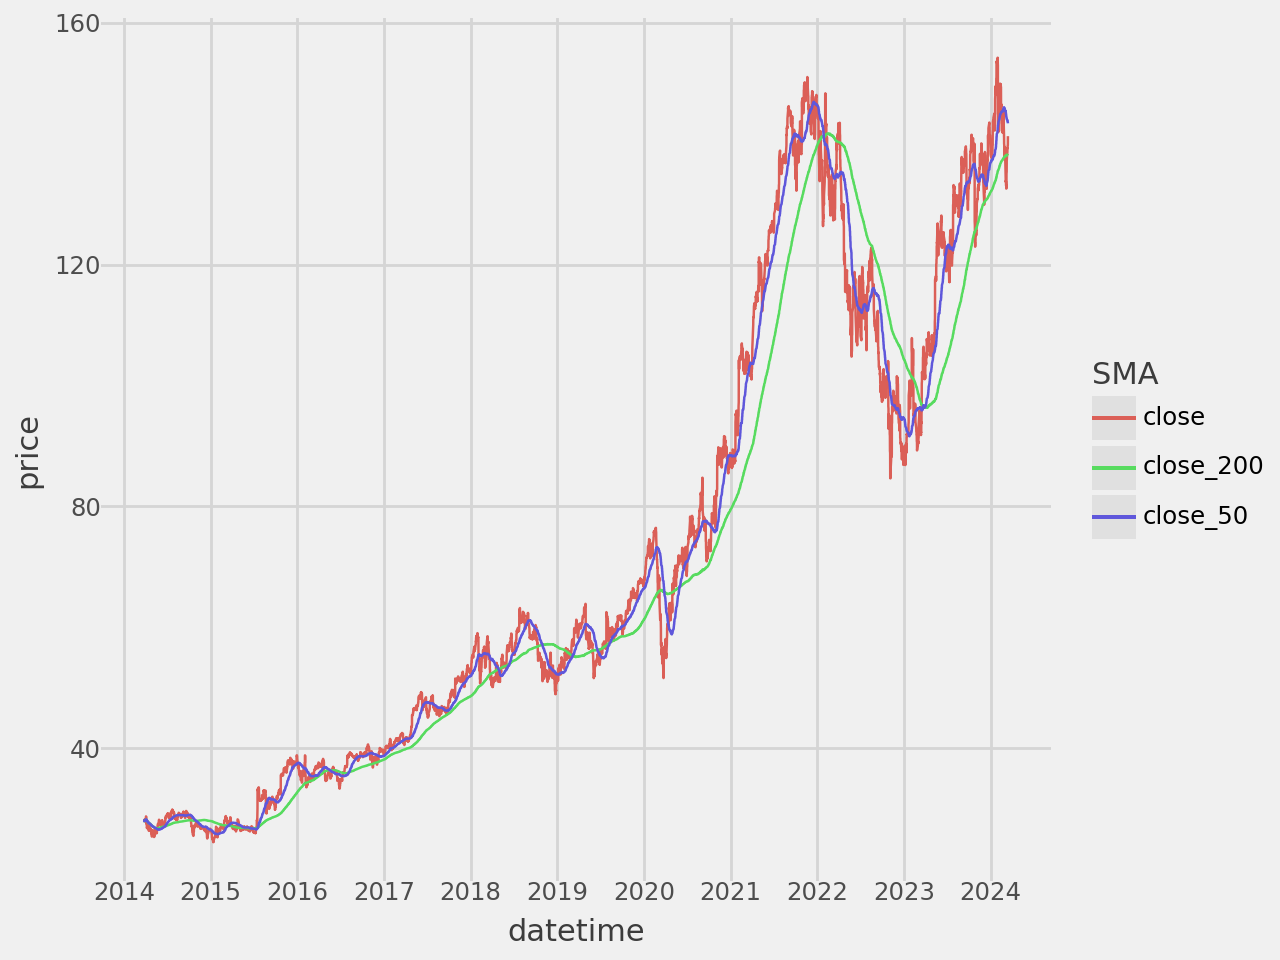

In [16]:
# Gallery, lines
(
    ggplot(goog_closing_value_p9, aes(x="datetime", y="price", color="SMA"))
    + geom_line()
    # Styling
    + scale_x_datetime(date_breaks="1 year", date_labels="%Y")
    + theme_538()
)

# Summary

With `cudf.pandas`, you can keep using pandas as your primary dataframe library if you enjoy using it but want faster performance. When things start to get a little slow, just load the `cudf.pandas` and run your existing code on a GPU!

If you like Google Colab and want to get peak cudf.pandas performance to process even larger datasets, Google Colab's paid tier includes both L4 and A100 GPUs (in addition to the T4 GPU this demo notebook is using).

To learn more about cudf.pandas, we encourage you to visit [rapids.ai/cudf-pandas](https://rapids.ai/cudf-pandas).